# Effect of basis degree, penalty and knots on estimated mean and covariance surface

In [1]:
#detach("package:elasdics2d", unload=TRUE)
devtools::install("../../elasdics")
library(elasdics2d)
library(ggplot2)
library(grid)
library(gridExtra)
library(dplyr)
library(cowplot)

# Display plots in smaller size
options(repr.plot.width=15, repr.plot.height=5)

Skipping 1 packages not available: numDeriv



v  checking for file 'D:\Dropbox\Statistik\elasdics/DESCRIPTION'
-  preparing 'elasdics2d': (416ms)
v  checking DESCRIPTION meta-information
-  checking for LF line-endings in source and make files and shell scripts (335ms)
-  checking for empty or unneeded directories
-  building 'elasdics2d_0.1.0.tar.gz'
   
Running "C:/R/R-4.0.5/bin/x64/Rcmd.exe" INSTALL \
  "C:\Users\manue\AppData\Local\Temp\RtmpQnkQFd/elasdics2d_0.1.0.tar.gz" \
  --install-tests 
* installing to library 'C:/R/R-4.0.5/library'
* installing *source* package 'elasdics2d' ...
** using staged installation
** R
** tests
** byte-compile and prepare package for lazy loading
** help
No man pages found in package  'elasdics2d' 
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
*** arch - i386
*** arch - x64
** testing if installed package can be loaded from final location
*** arch - i386
*** arch - x64
** testing if installed package keeps a record 


Attaching package: 'dplyr'


The following object is masked from 'package:gridExtra':

    combine


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




Load some datasets with random rotation and scaling.

In [2]:
source("../scripts/load_datasets.R")


set.seed(18)

spirals <- curves.spiral(n_curves=10, rotate=TRUE, scale=TRUE, center=TRUE)
digits3 <- curves.digit3(rotate=TRUE, scale=TRUE, center=TRUE)


Normalize curves.

In [3]:
normalize_curve <- function(curve) {
    dx = diff(curve$X1)
    dy = diff(curve$X2)
    dt = diff(curve$t)
    l = sum(sqrt(dx^2 + dy^2))
    curve$X1 = curve$X1 / l
    curve$X2 = curve$X2 / l
    curve
}


spirals <- lapply(spirals, normalize_curve)
digits3 <- lapply(digits3, normalize_curve)

Take a look at the data curves.

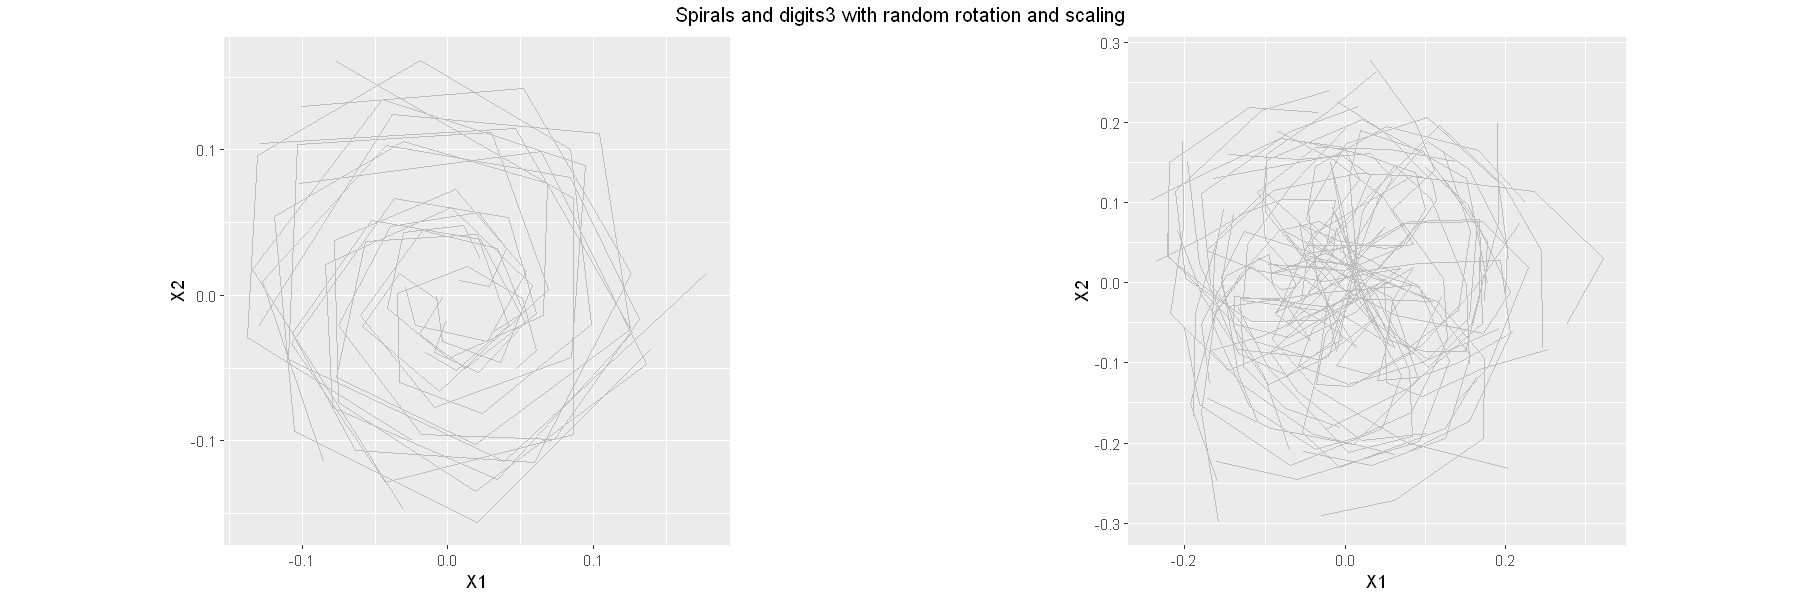

In [4]:
p1 <- ggplot(bind_rows(spirals, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(size=0.5, aes(group=id), color="grey") +
    coord_fixed()

p2 <- ggplot(bind_rows(digits3, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(size=0.5, aes(group=id), color="grey") +
    coord_fixed()

grid.arrange(p1, p2, nrow=1, top="Spirals and digits3 with random rotation and scaling")

Define functions for plotting.

In [5]:

plot_cov_surface<- function(cov_fit, h=0.01){
  # Define covariance surface grid (s,t).
  arg.grid = seq(0, 1, by=h)
  cov.grid = expand.grid(t = arg.grid, s = arg.grid)
  # Evaluate fit on grid.
  cov.re = predict(cov_fit$re, newdata = cov.grid)
  cov.im = predict(cov_fit$im, newdata = cov.grid)

  par(mfrow=c(1,2), mar=c(4,4,4,1), oma=c(0.5,0.5,0.5,0))
  # From 'fdapace/src/R/CreateCovPlot.R'
  args1 <- list(
    xlab='t', ylab='s', zlab = 'C(s,t)',
    main = 'Smoothed covariance surface (real part)'
  )
  args2 = list (x = arg.grid, y = arg.grid, z = matrix(cov.re, nrow=101))
  do.call(plot3D::persp3D, c(args2, args1))

  # From 'fdapace/src/R/CreateCovPlot.R'
  args1 <- list(
    xlab='t', ylab='s', zlab = 'C(s,t)',

    main = 'Smoothed covariance surface (imaginary part)'
  )
  args2 = list (x = arg.grid, y = arg.grid, z = matrix(cov.im,nrow=101))
  do.call(plot3D::persp3D, c(args2, args1))
}

library(grid)


plot_all <- function(mean, h=0.01){
    
  cov_fit <- mean$cov_fit
  # Define covariance surface grid (s,t).
  arg.grid = seq(0, 1, by=h)
  cov.grid = expand.grid(t = arg.grid, s = arg.grid)
  # Evaluate fit on grid.
  cov.re = predict(cov_fit$re, newdata = cov.grid)
  cov.im = predict(cov_fit$im, newdata = cov.grid)

  par(mfrow=c(1,3), mar=c(4,4,4,1), oma=c(0.33,0.33,0.33,0))
 
  # From 'fdapace/src/R/CreateCovPlot.R'
  args1 <- list(
    xlab='t', ylab='s', zlab = 'C(s,t)',
    main = 'Smoothed covariance surface (real part)'
  )
  args2 = list (x = arg.grid, y = arg.grid, z = matrix(cov.re, nrow=101))
  do.call(plot3D::persp3D, c(args2, args1))

  # From 'fdapace/src/R/CreateCovPlot.R'
  args1 <- list(
    xlab='t', ylab='s', zlab = 'C(s,t)',

    main = 'Smoothed covariance surface (imaginary part)'
  )
  args2 = list (x = arg.grid, y = arg.grid, z = matrix(cov.im,nrow=101))
  do.call(plot3D::persp3D, c(args2, args1))

  vp.Right <- viewport(height=unit(1, "npc"), width=unit(0.33, "npc"), 
                           just=c("left","top"), 
                           y=1, x=0.66)
  p <- ggplot(bind_rows(mean$pfits, .id="id"), aes(x=X1, y=X2)) + 
      geom_path(aes(group=id), size = 0.5, color="grey") +
      geom_path(data=get_evals(mean), aes(x=X1, y=X2), color = "red", size = 1) +
      coord_fixed()
  print(p, vp=vp.Right)
}

## Testing Parameters

In [6]:
order <- list("polygon", "smooth", "cubic")
penalty <- list(0, 1, 2)
knots <- lapply(list(9, 11, 17, 31, 51), function(nknots){
    seq(0, 1, length = nknots)
})

In [7]:
# Turn of warnings
defaultW <- getOption("warn")
options(warn = -1)

## Spirals

In [8]:
spiral.means <- lapply(order, function(type){
    lapply(penalty, function(pen){
        start_time <- Sys.time()
        knots <- seq(0, 1, length = 19)
        print(paste0("Computing spirals mean:  Type = ", type, "  Penalty = ", pen, "  #Knots = ", length(knots)))
        flush.console()
        mean <- compute_elastic_mean(spirals, knots = knots, type = type, proc2d = TRUE, penalty = pen)
        print(Sys.time() - start_time)
        flush.console()
        mean
    })
})

[1] "Computing spirals mean:  Type = polygon  Penalty = 0  #Knots = 19"
Time difference of 32.80076 secs
[1] "Computing spirals mean:  Type = polygon  Penalty = 1  #Knots = 19"
Time difference of 36.09213 secs
[1] "Computing spirals mean:  Type = polygon  Penalty = 2  #Knots = 19"
Time difference of 29.52199 secs
[1] "Computing spirals mean:  Type = smooth  Penalty = 0  #Knots = 19"
Time difference of 27.13183 secs
[1] "Computing spirals mean:  Type = smooth  Penalty = 1  #Knots = 19"
Time difference of 18.45477 secs
[1] "Computing spirals mean:  Type = smooth  Penalty = 2  #Knots = 19"
Time difference of 13.62877 secs
[1] "Computing spirals mean:  Type = cubic  Penalty = 0  #Knots = 19"
Time difference of 1.107333 mins
[1] "Computing spirals mean:  Type = cubic  Penalty = 1  #Knots = 19"
Time difference of 23.81095 secs
[1] "Computing spirals mean:  Type = cubic  Penalty = 2  #Knots = 19"
Time difference of 29.57458 secs


[1] "Type = polygon  Penalty = 0  #Knots = 19"


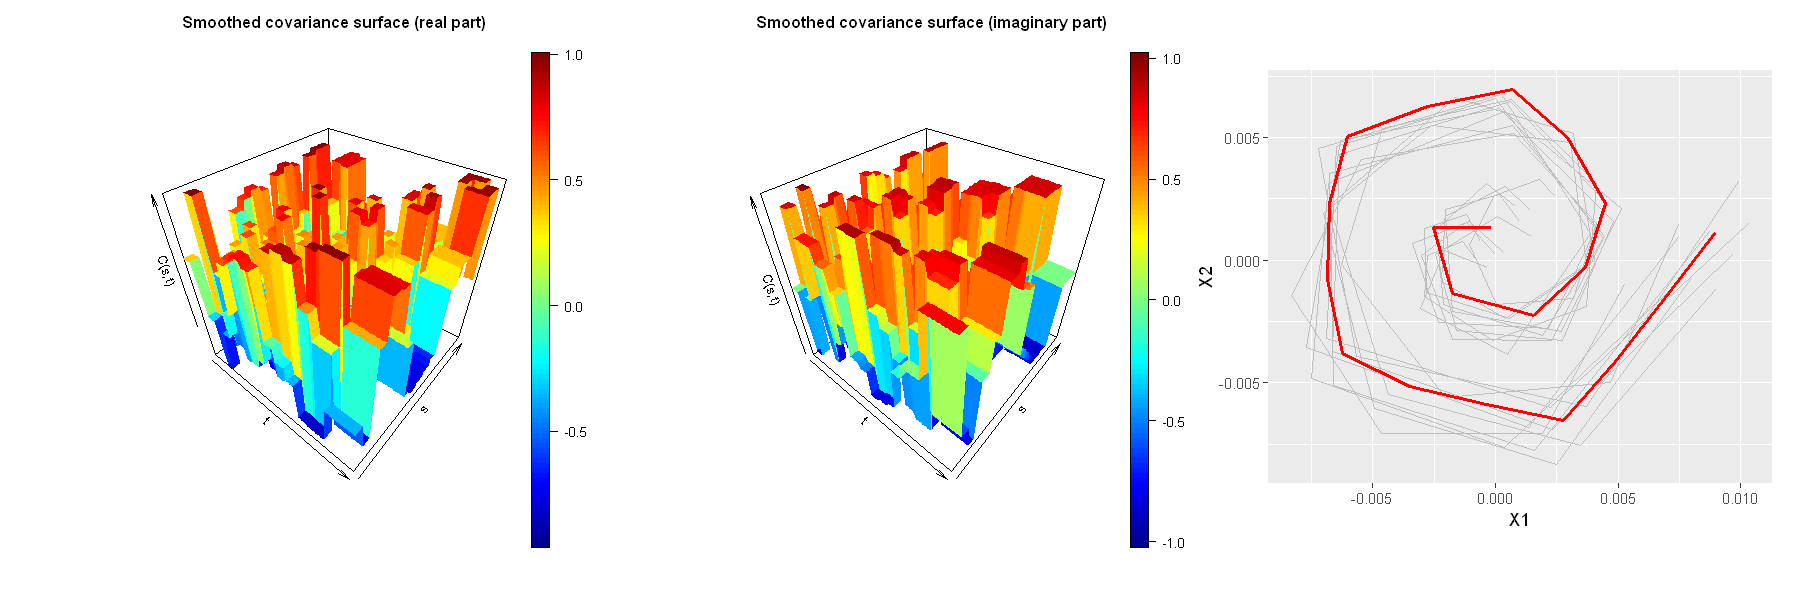

[1] "Type = polygon  Penalty = 1  #Knots = 19"


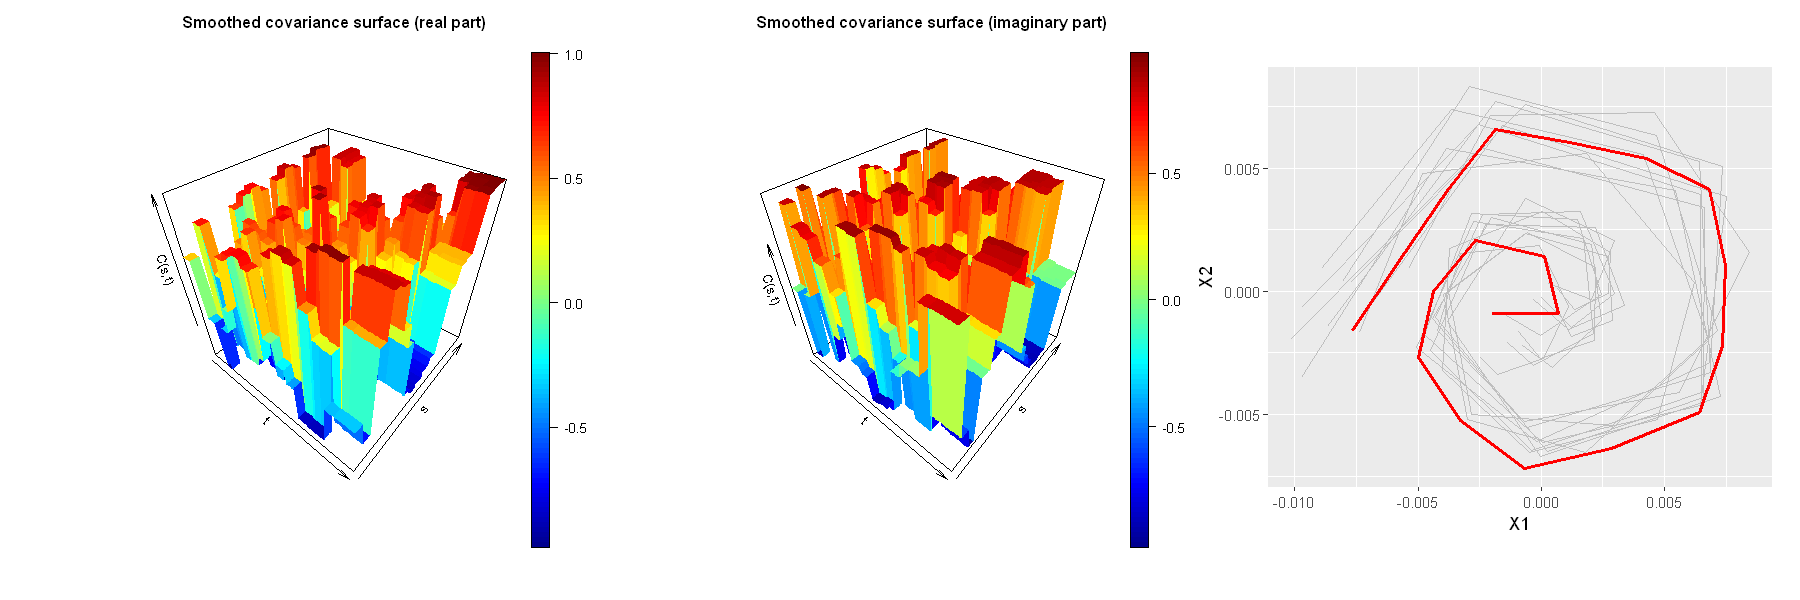

[1] "Type = polygon  Penalty = 2  #Knots = 19"


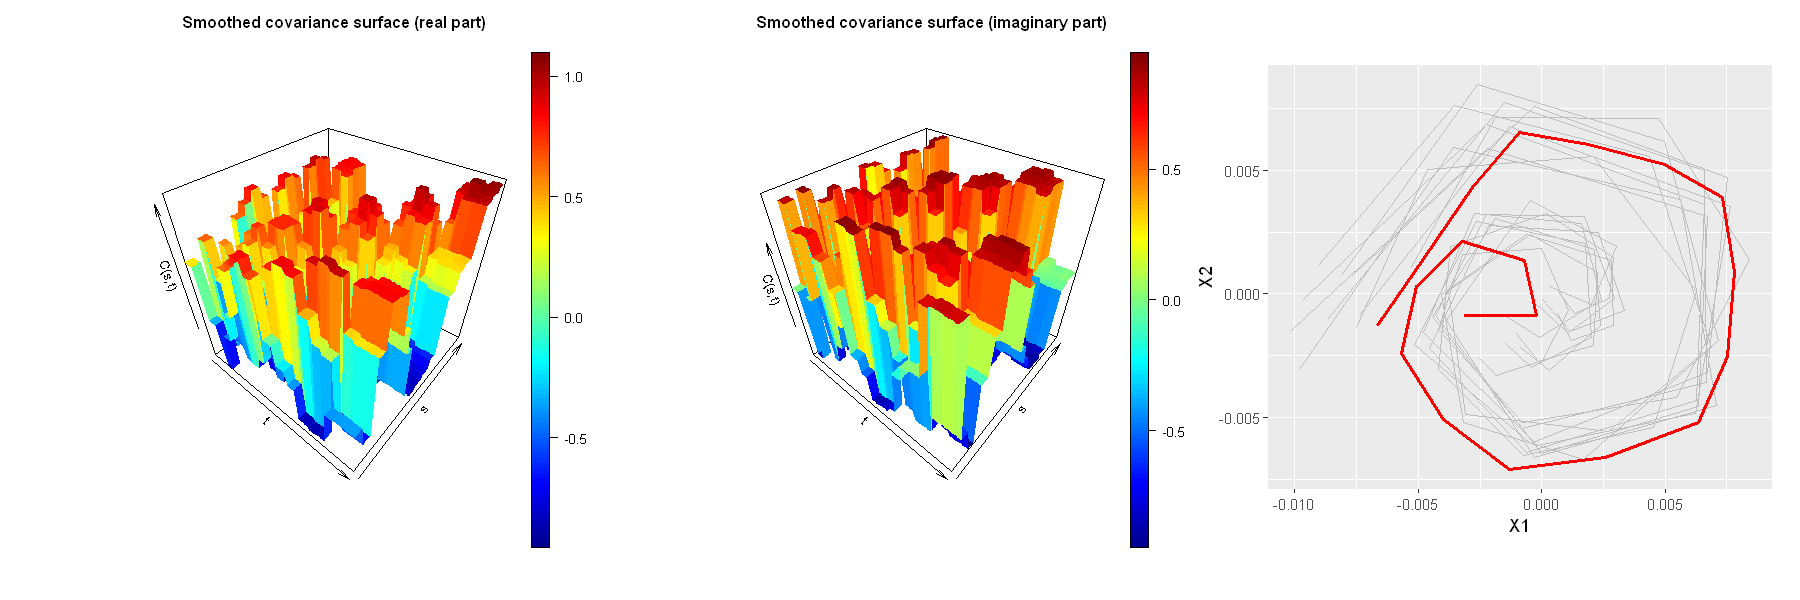

[1] "Type = smooth  Penalty = 0  #Knots = 19"


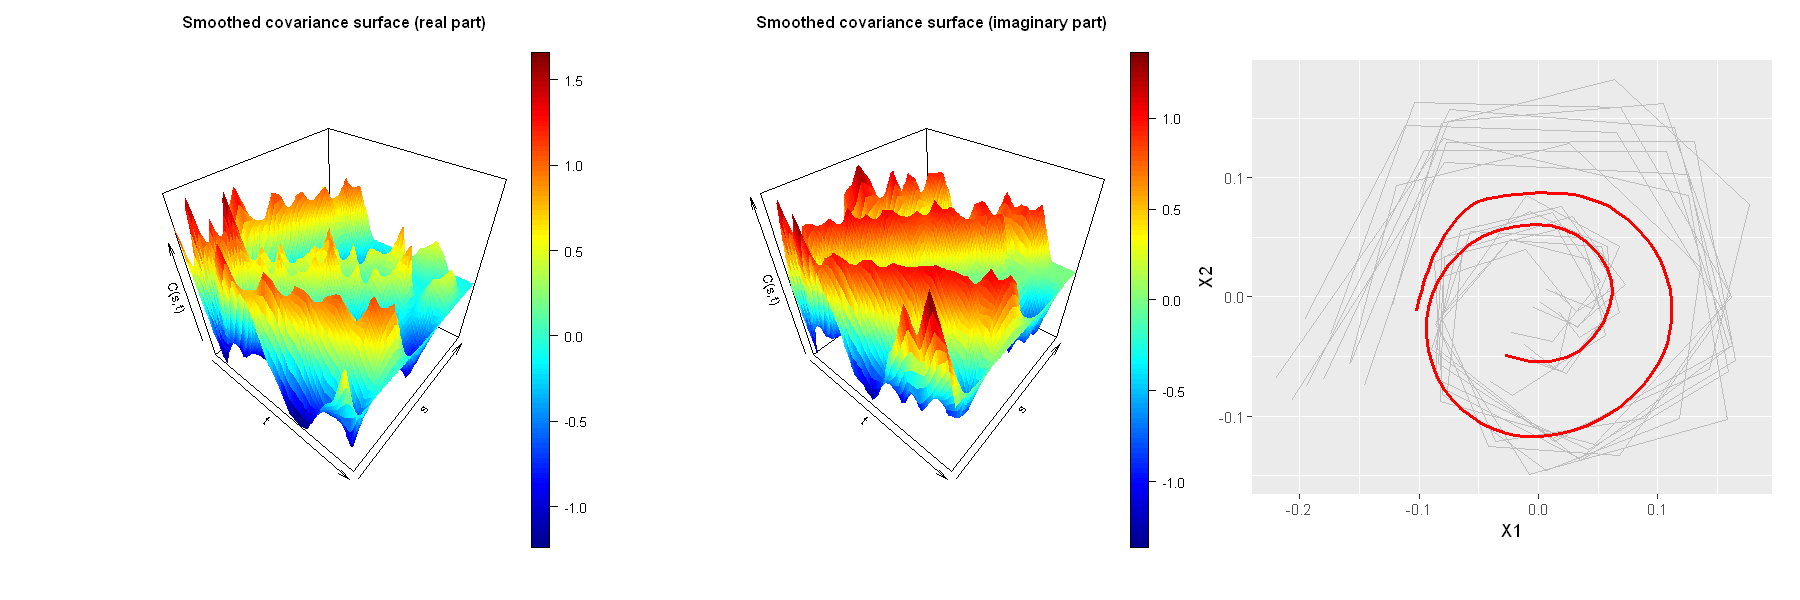

[1] "Type = smooth  Penalty = 1  #Knots = 19"


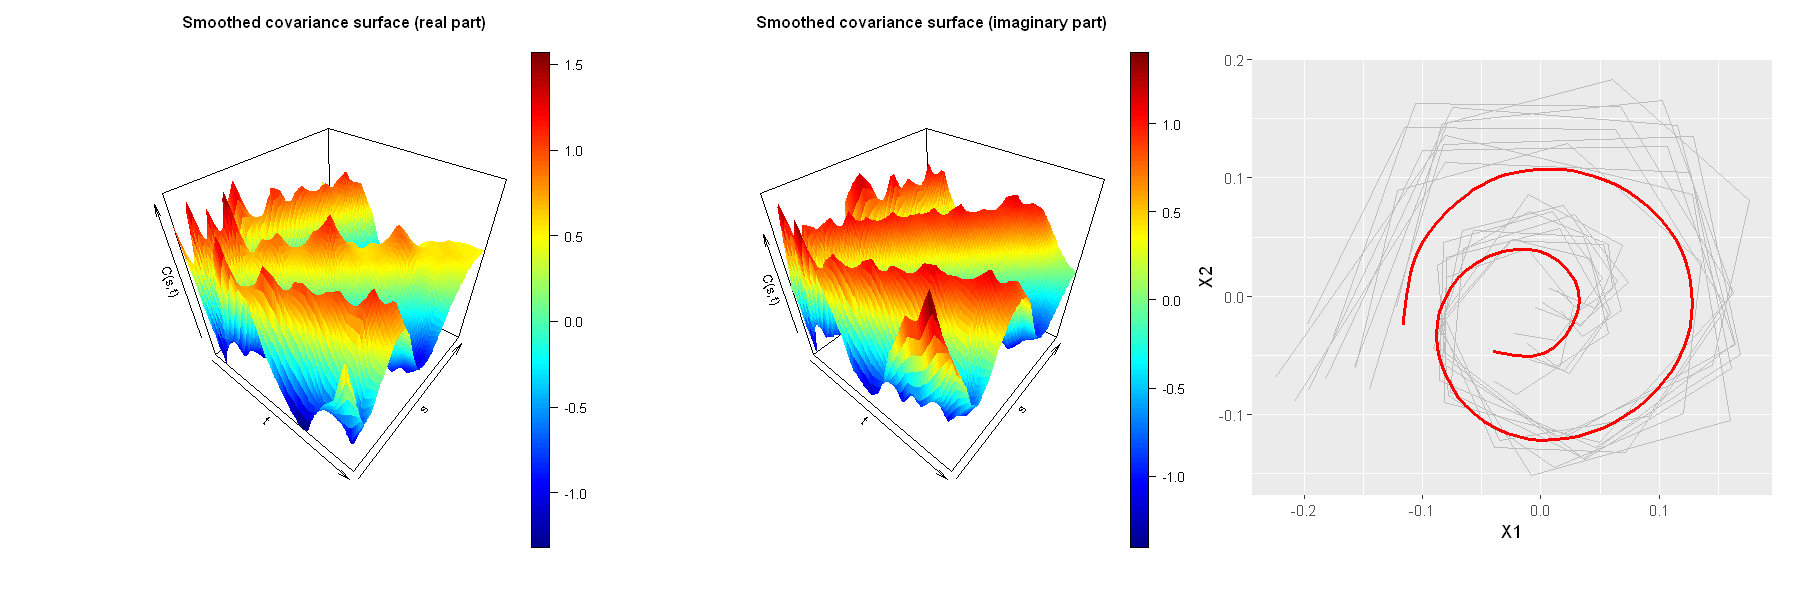

[1] "Type = smooth  Penalty = 2  #Knots = 19"


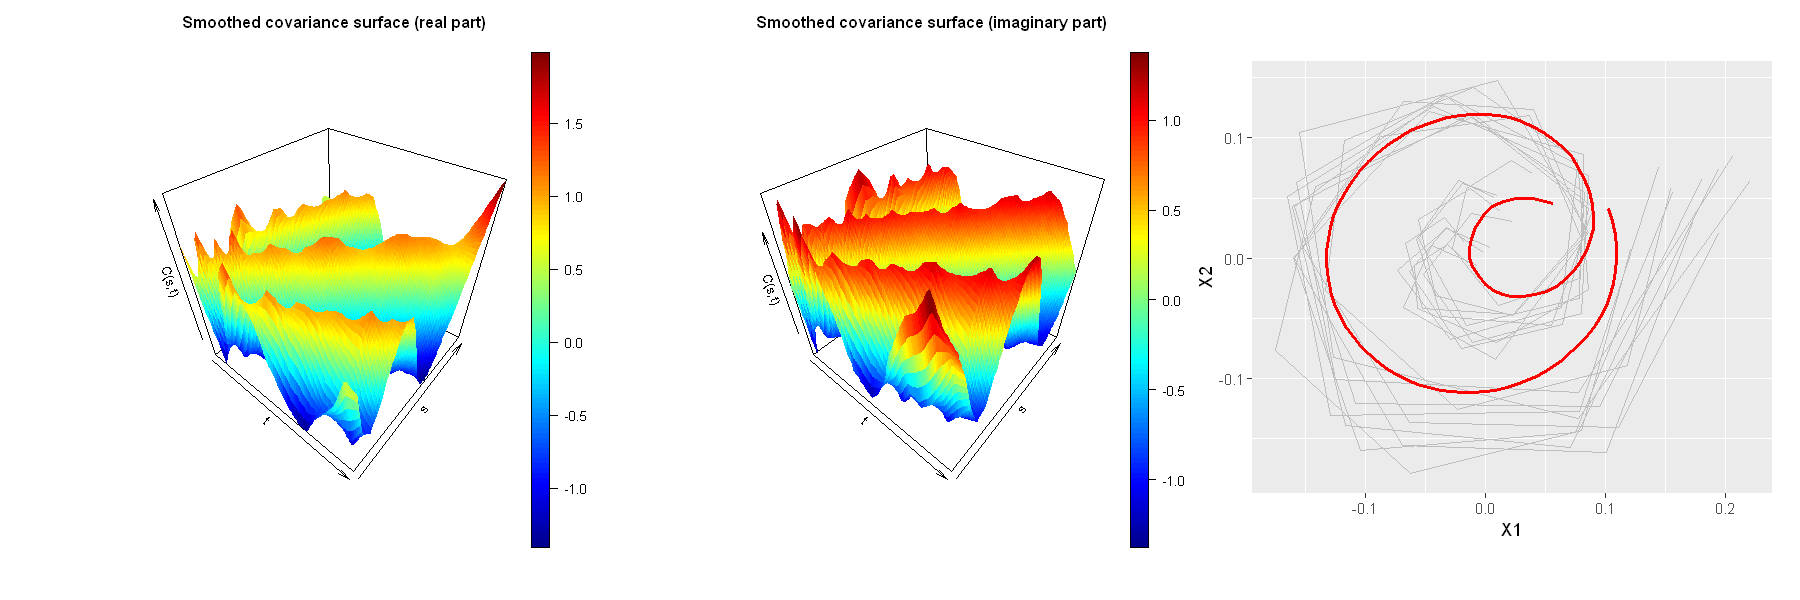

[1] "Type = cubic  Penalty = 0  #Knots = 19"


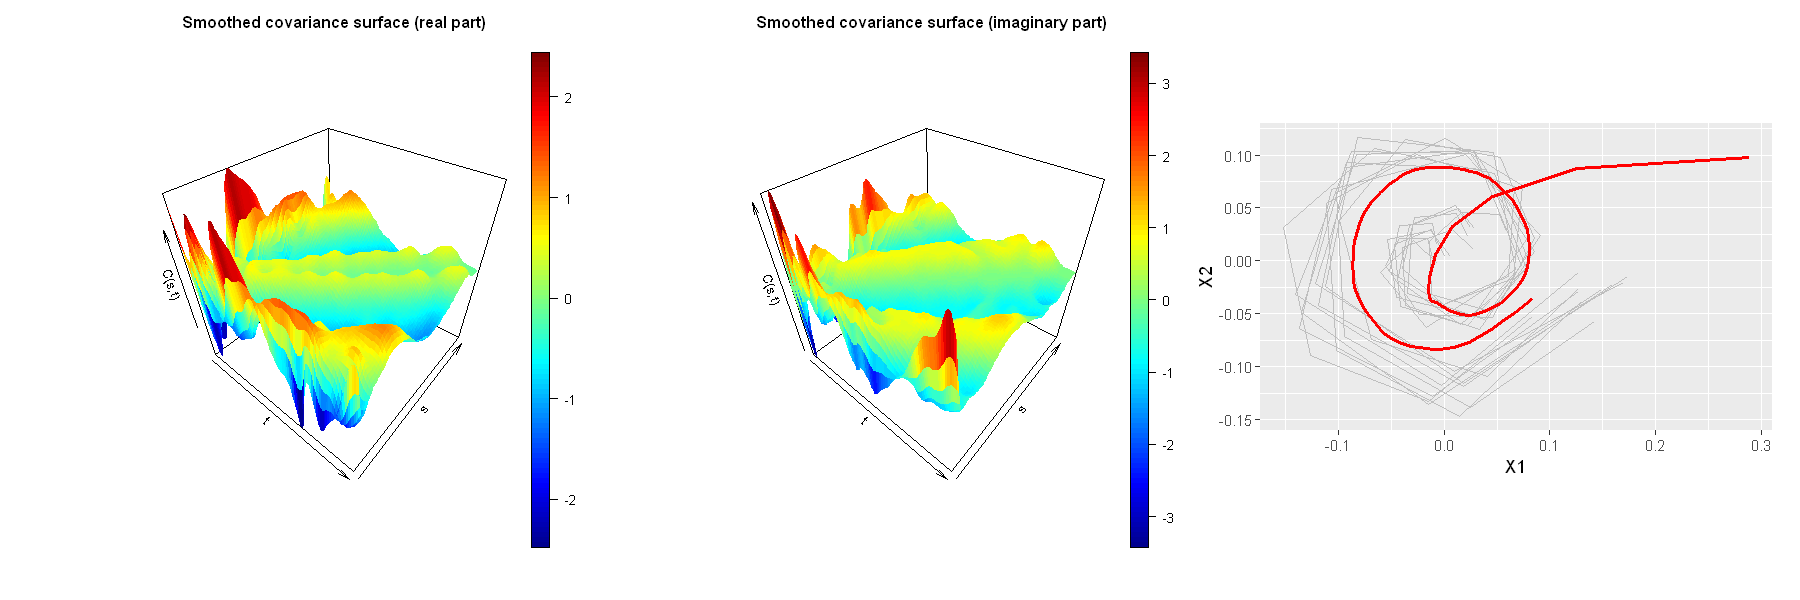

[1] "Type = cubic  Penalty = 1  #Knots = 19"
[1] "Type = cubic  Penalty = 2  #Knots = 19"


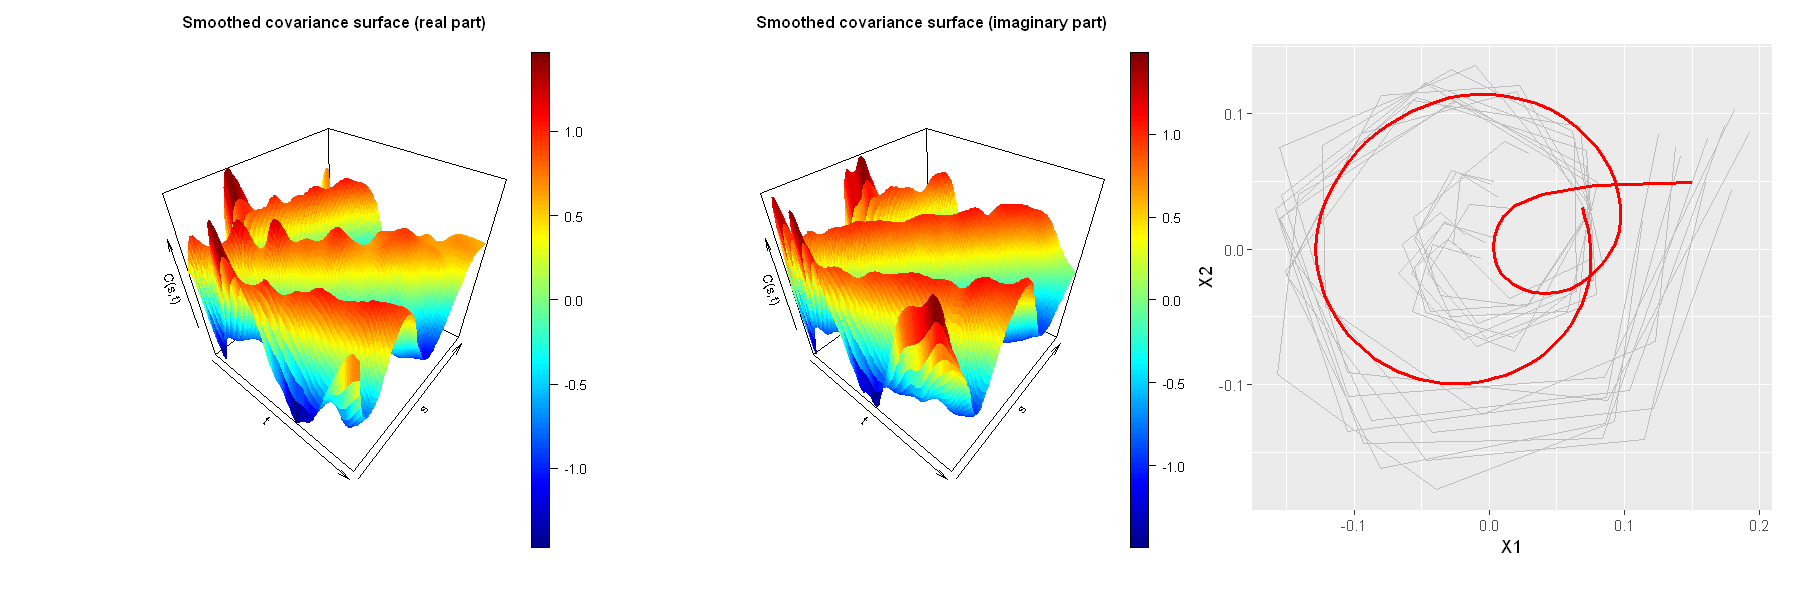

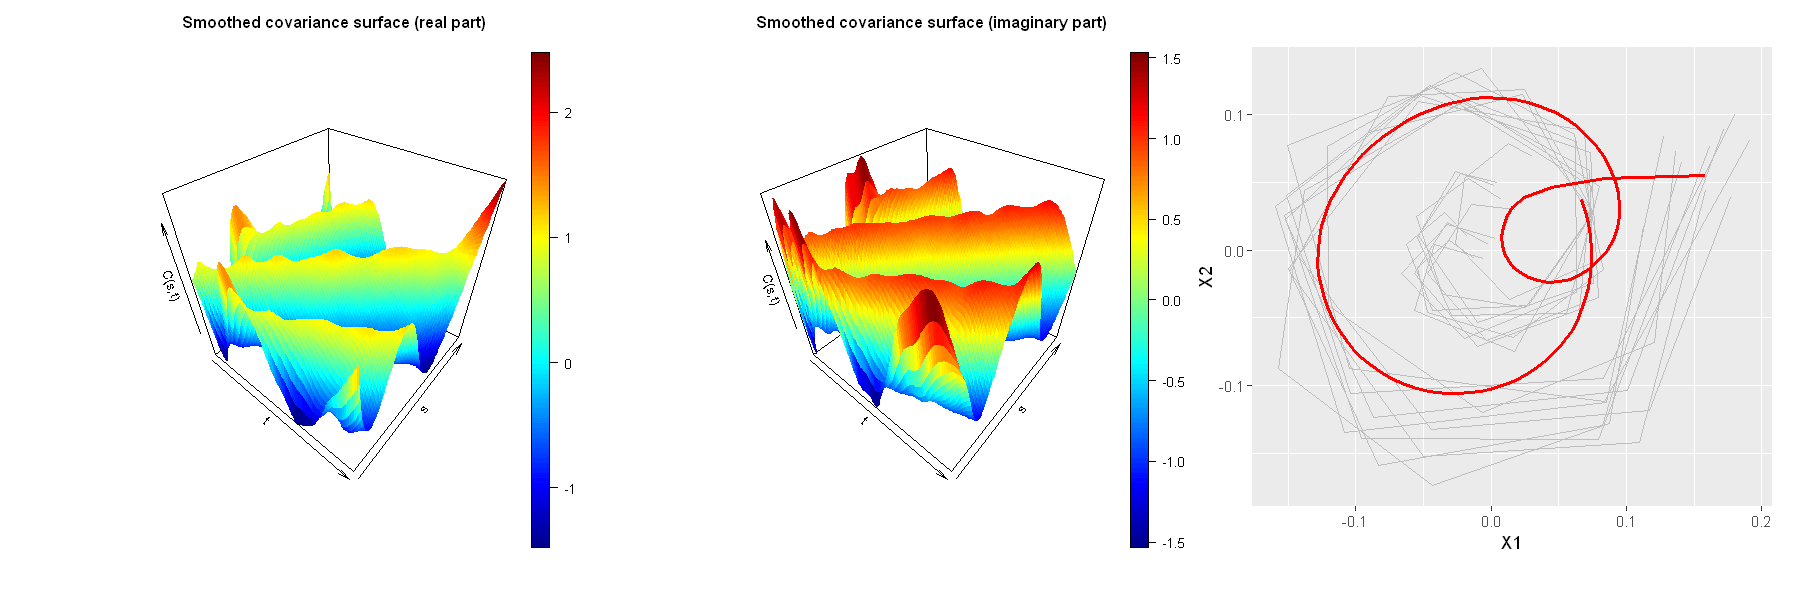

In [9]:
void <- lapply(1:length(order), function(i){
    lapply(1:length(penalty), function(j){
        mean <- spiral.means[[i]][[j]]
        plot_all(mean)
        print(paste0("Type = ", mean$type, "  Penalty = ", penalty[[j]], "  #Knots = ", length(mean$knots)))
    })
})

## Digits3

In [10]:
digits3.means <- lapply(order, function(type){
    lapply(penalty, function(pen){
        start_time <- Sys.time()
        knots <- seq(0, 1, length = 13)
        print(paste0("Computing digits3 mean:  Type = ", type, "  Penalty = ", pen, "  #Knots = ", length(knots)))
        flush.console()
        mean <- compute_elastic_mean(digits3, knots = knots, type = type, proc2d = TRUE, penalty = pen)
        print(Sys.time() - start_time)
        flush.console()
        mean
    })
})

[1] "Computing digits3 mean:  Type = polygon  Penalty = 0  #Knots = 13"


ERROR: Error in while (mean(ldxx/(ldxx + ldss)) > 0.4) {: missing value where TRUE/FALSE needed


In [ ]:
void <- lapply(1:length(order), function(i){
    lapply(1:length(penalty), function(j){
        mean <- digits3.means[[i]][[j]]
        plot_all(mean)
        print(paste0("Type = ", mean$type, "  Penalty = ", penalty[[j]], "  #Knots = ", length(mean$knots)))
    })
})